<a href="https://www.kaggle.com/code/abhijitdarekar001/trading-agent-bot-dql?scriptVersionId=156794878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#### Importing Libraries

In [53]:
import math
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import pandas_datareader as data_reader
from tqdm import tqdm
from collections import deque
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')


### AI Trader Model

In [54]:
class AiTrader:
    def __init__(self,states_size, action_space = 3, model_name = 'Ai Trader', ):
        """
        action_space : Incase of trading Bot action space is 3 as there are 3 required action needs to be taken, Buy, Sell and Stay
        """
        
        self.states_size = states_size
        self.action_space = action_space
        #  There are 3 spaces for Trading , which are
        # 1. Buy
        # 2. Sell
        # 3. Stay
        self.model_name = model_name
        self.inventory = []
        self.memory = deque(maxlen=2000)
        
        # Gamma is Discount Factor
        self.gaama = 0.95
        
        # Learning Rate
        self.epislon = 1.0
        
        # Final Learning Rate
        self.epislon_final = 0.25
        
        #Learning Rate Decay
        self.epislon_decay = 0.995
        
        self.model = self.model_builder()
        
    def model_builder(self):
        """
        Deep Q-learning Model.
        """
        
        model = tf.keras.Sequential()
        
        model.add(tf.keras.layers.Dense(input_dim = self.states_size,units=32, activation='relu'))
        
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        
        model.compile(loss= 'mse',optimizer= tf.keras.optimizers.Adam(learning_rate=0.001))
        
        return model
    
    def trade(self,state):
        """This method here sets the model for exploitation and exploration.
        the function returns one of below two valeus,
        Exporation : Returns Random action from action space if the agent is still in learning state.
        Exploitation : Return maximum likelihood of an action if model is not in learning state.
        """
        if random.random() <= self.epislon:
            return random.randrange(self.action_space)
        
        actions = self.model.predict(state)
        return np.argmax(actions[0])
    
    def train_batch(self, batch_size):
        """Argument can be anythig from 3 2to 1500"""
        
        batch = []
        
        for i in range(len(self.memory)-batch_size+1):
            batch.append(self.memory[i])
        
        for state,action,reward,next_state, done in batch:
            reward = reward
            
            # To check agent is not in terminal state
            if not done:
                reward  = reward + self.gaama*np.argmax(self.model.predict(next_state))
                
            target  = self.model.predict(state)
            target[0][action] = reward
            
            self.model.fit(state,target,epochs=1,verbose='auto')
            
        if self.epislon > self.epislon_final:
            self.epislon *= self.epislon_decay
                
        

#### Utils

In [55]:
def sigmoid(x):
    """Activation Function"""
    return 1/(1+ math.exp(-x))

In [56]:
def dataset_loader():
    """Returnt the Close form the dataset."""
  #Complete the dataset loader function
    dataset = pd.read_csv('/kaggle/input/fitb-data2/FITB.csv')
    dataset.Date = pd.to_datetime(dataset.Date)
    dataset = dataset.set_index('Date')#.sort_values('Date',ascending=False)
#     start_date = str(min(dataset.Date))
#     end_date = str(max(dataset.Date))
    close = dataset['Close']
    return close ,dataset


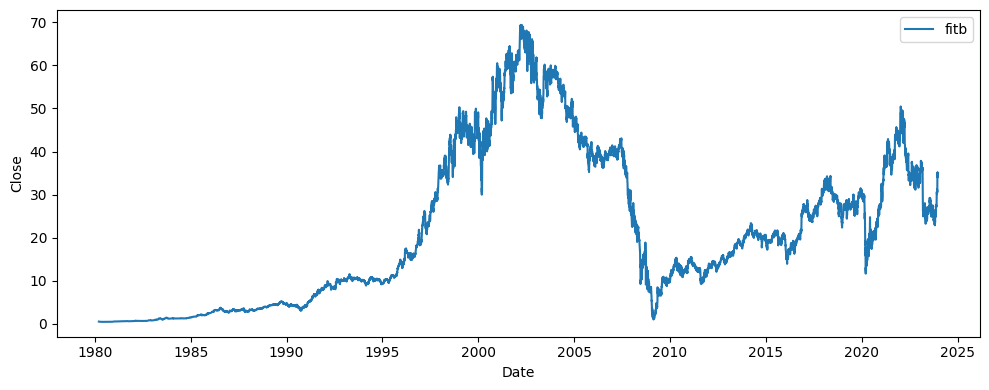

In [57]:
_,dataset = dataset_loader()
plt.figure(figsize=(10,4))
# sns.barplot(dataset,y = 'Volume')
sns.lineplot(dataset.Close,palette='pastel')
plt.legend(["fitb"])
plt.tight_layout()

In [58]:
def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
  
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])
    
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
    return np.array([state])

In [59]:
data,_ = dataset_loader()

In [60]:
WINDOW_SIZE = 10
EPOCHS = 1000

batch_size = 32

DATA_SAMPLES = len(data)-1

In [61]:
trader = AiTrader(WINDOW_SIZE)
trader.model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                352       
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dense_18 (Dense)            (None, 128)               8320      
                                                                 
 dense_19 (Dense)            (None, 3)                 387       
                                                                 
Total params: 11171 (43.64 KB)
Trainable params: 11171 (43.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training Loop

In [62]:

for epoch in range(EPOCHS):
    print(f"Epoch : {epoch:4}/{EPOCHS:4}")
    
    state = state_creator(data, 0 ,WINDOW_SIZE+1)
    
    total_profit=0
    trader.inventory = []
    
    for t in tqdm(range(DATA_SAMPLES)):
        action = trader.trade(state)
        
        next_state = state_creator(data, t+1, WINDOW_SIZE+1)
        
        reward = 0
        
        # Buying the stock
        if action ==1:
            trader.inventory.append(data[t])
            print(f"Algorithm Bought :{data[t]}")
        
        #Selling Price
        elif action == 2 and len(trader.inventory) > 0:
            buy_price = trader.inventory.pop()
            reward = max(data[t] - buy_price,0)
            
            total_profit += data[t]-buy_price
            print(f"AI Trader sold: {data[t]}, Profit: {data[t] - buy_price}")
        if t == DATA_SAMPLES-1:
            done = True
        else:
            done=False
        
        trader.memory.append((state, action, reward, next_state,done))
        
        state = next_state
        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")

        if len(trader.memory) > batch_size:
            trader.train_batch(batch_size)

    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))


Epoch :    0/1000


  0%|          | 0/11037 [00:00<?, ?it/s]

Algorithm Bought :0.543007
AI Trader sold: 0.539755, Profit: -0.0032520000000000326
Algorithm Bought :0.533252
AI Trader sold: 0.533252, Profit: 0.0
Algorithm Bought :0.516994
AI Trader sold: 0.510491, Profit: -0.0065029999999999255
Algorithm Bought :0.510491
Algorithm Bought :0.50724
Algorithm Bought :0.503988
AI Trader sold: 0.487731, Profit: -0.016256999999999966
AI Trader sold: 0.487731, Profit: -0.019509
AI Trader sold: 0.490982, Profit: -0.019509000000000054
Algorithm Bought :0.487731
Algorithm Bought :0.487731
AI Trader sold: 0.487731, Profit: 0.0
AI Trader sold: 0.487731, Profit: 0.0
Algorithm Bought :0.487731
Algorithm Bought :0.487731
AI Trader sold: 0.484479, Profit: -0.0032520000000000326
Algorithm Bought :0.484479
1/1 [==============================] - 0s 6ms/step - loss: 0.4060


  0%|          | 33/11037 [00:01<09:25, 19.45it/s]

AI Trader sold: 0.484479, Profit: 0.0
1/1 [==============================] - 0s 6ms/step - loss: 0.1606


  0%|          | 35/11037 [00:02<16:55, 10.83it/s]

1/1 [==============================] - 0s 6ms/step - loss: 0.1728


  0%|          | 36/11037 [00:03<23:52,  7.68it/s]

1/1 [==============================] - 0s 6ms/step - loss: 0.4174


  0%|          | 37/11037 [00:04<34:48,  5.27it/s]

1/1 [==============================] - 0s 6ms/step - loss: 0.5354


  0%|          | 38/11037 [00:05<50:48,  3.61it/s]

Algorithm Bought :0.484479
1/1 [==============================] - 0s 7ms/step - loss: 2.9657e-04


  0%|          | 39/11037 [00:06<1:12:12,  2.54it/s]

Algorithm Bought :0.477976
1/1 [==============================] - 0s 6ms/step - loss: 0.0212


  0%|          | 40/11037 [00:08<1:41:10,  1.81it/s]

Algorithm Bought :0.477976
1/1 [==============================] - 0s 6ms/step - loss: 0.0651


  0%|          | 41/11037 [00:10<2:14:32,  1.36it/s]

1/1 [==============================] - 0s 6ms/step - loss: 0.0081


  0%|          | 42/11037 [00:12<2:56:00,  1.04it/s]

Algorithm Bought :0.477976
1/1 [==============================] - 0s 6ms/step - loss: 0.0010


  0%|          | 43/11037 [00:13<3:35:52,  1.18s/it]

1/1 [==============================] - 0s 7ms/step - loss: 0.0061


  0%|          | 44/11037 [00:16<4:18:06,  1.41s/it]

1/1 [==============================] - 0s 6ms/step - loss: 4.1702e-04


  0%|          | 45/11037 [00:18<5:00:08,  1.64s/it]

AI Trader sold: 0.477976, Profit: 0.0
1/1 [==============================] - 0s 6ms/step - loss: 0.0145


  0%|          | 46/11037 [00:20<5:38:15,  1.85s/it]

Algorithm Bought :0.477976
1/1 [==============================] - 0s 18ms/step


  0%|          | 46/11037 [00:21<1:27:02,  2.10it/s]


KeyboardInterrupt: 